### **LUNAR LANDER DQN KERAS**

This is a naive version of the CARTPOLE DQN algorithm <br>
 <br>
Try to make it faster by doing some hyperparameter optimization  <br>
Try to explore less. Does it accelerates convergence?  <br>
Increasing the ```ROLLING_WINDOW``` value will gnerate slower agent convergence but the Agent behavior will be more consistent <br>

An issue you may find is a lander that hovers forever. This happens because it has been programmed with infinite fuel. You can see it in this execution in the lines that are marked as ```Terminated=False```. Without modifying the environment, there are a couple of things that can be done to ameliorate this behavior <br>

1. **Limit number of steps** In this case we are limiting the number of steps to 1200
2. **Increase gravity** The default gravity in this environment is -10.0, you can increase it up to -12.0, increasing it you'll have a faster descent and hovering becomes more difficult ```env = gym.make("LunarLander-v3", gravity=11.0)```




In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import random
import gymnasium as gym
import time
import numpy as np
from collections import deque
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import sys
sys.stderr = open('err.txt', 'w')

Num GPUs Available:  1


I0000 00:00:1739000290.050763   11770 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739000290.070425   11770 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739000290.070471   11770 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739000290.142483   11770 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739000290.142570   11770 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [2]:
# GPU
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Using device: 0, name: NVIDIA T600 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5


#### **Hyperparameters**

In [3]:
# Set up hyperparameters
MAX_EPISODES = 1500
ROLLING_WINDOW = 40
MEMORY_SIZE = 100000
MAX_STEPS = 1200

gamma = 0.99                         # discount rate
epsilon = 1.0                        # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.99
learning_rate = 0.0001
batch_size = 64
solved_threshold = 200

verb = 0                             # to see traces (verbosity)

In [4]:
# Environment setup
env = gym.make('LunarLander-v3')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

#### **Neural Network**

In [5]:
def build_model(state_size, action_size):
    inputs = Input(shape=(state_size,), name="input_layer")
    x = Dense(128, activation='relu', name="hidden_1")(inputs)
    x = Dense(64, activation='relu', name="hidden_2")(x)
    x = Dense(32, activation='relu', name="hidden_3")(x)
    outputs = Dense(action_size, activation='linear', name="output_layer")(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="Q_Network")
#    model.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mse') # to improve train stability
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

#### **Support Functions**

In [6]:
replay_buffer = deque(maxlen=MEMORY_SIZE)

def store(state, action, reward, next_state, done):             # memorize
    replay_buffer.append((state, action, reward, next_state, done))

def select_action_greedy(state, DQN):                                      # act
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    act_values = DQN.predict(state, verbose=verb)
    return np.argmax(act_values[0])  # returns action selected with greedy strategy

# Sample experiences from the replay buffer
def sample_experiences(batch_size):
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
    batch = [replay_buffer[i] for i in indices]
    states, actions, rewards, next_states, dones = zip(*batch)
    return (
        np.vstack(states),
        np.array(actions),
        np.array(rewards),
        np.vstack(next_states),
        np.array(dones, dtype=np.float32)
    )

    
def experience_replay(batch_size, model, epsilon):
    if len(replay_buffer) < batch_size:
        return
    minibatch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)

    # Predict Q-values for current and next states using vectorized operations
    target_qs = model.predict(states, verbose=verb)
    next_qs   = model.predict(next_states, verbose=verb)

    # Update target Q-values using standard DQN logic   
    target_qs[np.arange(batch_size), actions] = rewards + gamma * np.max(next_qs, axis=1) * (1 - dones)
    
#    for i in range(batch_size):
#        if dones[i]:
#            target_qs[i, actions[i]] = rewards[i]
#        else:
#            target_qs[i, actions[i]] = rewards[i] + gamma * np.max(next_qs[i])

    # Train the model on the Q-values
    model.fit(states, target_qs, epochs=1, verbose=0)

def load(name, DQN):
    DQN.load_weights(name)

def save(name, DQN):
    DQN.save_weights(name)

DQN = build_model(state_size, action_size)
DQN.summary()

Model: "Q_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,620 (45.39 KB)

 Trainable params: 11,620 (45.39 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
rewards_per_episode= []
start_time = time.time()

done = False
rolling_avg = 0
rolling_avg_rewards = []

for e in range(MAX_EPISODES):                           # Should be While True, however we limit number of eps
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    for step in range(MAX_STEPS):
            
        action = select_action_greedy(state, DQN)
        next_state, reward, done, truncated , _ = env.step(action)
                    
        next_state = np.reshape(next_state, [1, state_size])
        store(state, action, reward, next_state, done)
        state = next_state
        total_reward = total_reward + reward
        if done:
            break
            
        if len(replay_buffer) > batch_size:
            experience_replay(batch_size, DQN, epsilon)
            
    epsilon = max(epsilon_min, epsilon * epsilon_decay)            # decay epsilon
    
    rewards_per_episode.append(total_reward)
    rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])   # append rewards
    rolling_avg_rewards.append(rolling_avg)
    print(f"Episode: {e+1:3}/{MAX_EPISODES}, Reward: {total_reward:+7.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:7.2f}, Steps: {step:4} Terminated: {done} ")

            
    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {e+1} episodes!")
#            model.save("lunarlander_ddqn_model1.keras")
        break
    
end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")

Episode:   1/1500, Reward:  -59.62, Epsilon: 0.99, Rolling Avg:  -59.62, Steps:   76 Terminated: True 
Episode:   2/1500, Reward: -421.06, Epsilon: 0.98, Rolling Avg: -240.34, Steps:  109 Terminated: True 
Episode:   3/1500, Reward: -189.97, Epsilon: 0.97, Rolling Avg: -223.55, Steps:   72 Terminated: True 
Episode:   4/1500, Reward: -251.26, Epsilon: 0.96, Rolling Avg: -230.48, Steps:  137 Terminated: True 
Episode:   5/1500, Reward: -136.74, Epsilon: 0.95, Rolling Avg: -211.73, Steps:   89 Terminated: True 
Episode:   6/1500, Reward: -174.50, Epsilon: 0.94, Rolling Avg: -205.52, Steps:   90 Terminated: True 
Episode:   7/1500, Reward: -100.54, Epsilon: 0.93, Rolling Avg: -190.53, Steps:   66 Terminated: True 
Episode:   8/1500, Reward:  -98.27, Epsilon: 0.92, Rolling Avg: -178.99, Steps:  125 Terminated: True 
Episode:   9/1500, Reward:  +59.36, Epsilon: 0.91, Rolling Avg: -152.51, Steps:   83 Terminated: True 
Episode:  10/1500, Reward: -185.06, Epsilon: 0.90, Rolling Avg: -155.76, 

Episode:  81/1500, Reward: -127.62, Epsilon: 0.44, Rolling Avg: -104.50, Steps:  467 Terminated: True 
Episode:  82/1500, Reward: -153.57, Epsilon: 0.44, Rolling Avg: -104.29, Steps:  148 Terminated: True 
Episode:  83/1500, Reward: -115.23, Epsilon: 0.43, Rolling Avg: -105.63, Steps:  107 Terminated: True 
Episode:  84/1500, Reward: -142.68, Epsilon: 0.43, Rolling Avg: -105.10, Steps:  189 Terminated: True 
Episode:  85/1500, Reward:  -65.18, Epsilon: 0.43, Rolling Avg: -104.15, Steps:  199 Terminated: True 
Episode:  86/1500, Reward:  -71.11, Epsilon: 0.42, Rolling Avg: -102.69, Steps:  254 Terminated: True 
Episode:  87/1500, Reward: -136.19, Epsilon: 0.42, Rolling Avg: -106.51, Steps:  172 Terminated: True 
Episode:  88/1500, Reward:  -90.70, Epsilon: 0.41, Rolling Avg: -107.41, Steps:  235 Terminated: True 
Episode:  89/1500, Reward:   -2.43, Epsilon: 0.41, Rolling Avg: -105.68, Steps:   98 Terminated: True 
Episode:  90/1500, Reward: -370.22, Epsilon: 0.40, Rolling Avg: -112.43, 

Episode: 161/1500, Reward: +176.00, Epsilon: 0.20, Rolling Avg:   18.15, Steps:  893 Terminated: True 
Episode: 162/1500, Reward:  -83.03, Epsilon: 0.20, Rolling Avg:   16.47, Steps:  106 Terminated: True 
Episode: 163/1500, Reward: +159.97, Epsilon: 0.19, Rolling Avg:   21.47, Steps:  925 Terminated: True 
Episode: 164/1500, Reward:  +71.12, Epsilon: 0.19, Rolling Avg:   22.99, Steps: 1199 Terminated: False 
Episode: 165/1500, Reward:  -31.33, Epsilon: 0.19, Rolling Avg:   23.87, Steps:  168 Terminated: True 
Episode: 166/1500, Reward: +230.48, Epsilon: 0.19, Rolling Avg:   30.57, Steps:  799 Terminated: True 
Episode: 167/1500, Reward: +205.09, Epsilon: 0.19, Rolling Avg:   37.36, Steps:  849 Terminated: True 
Episode: 168/1500, Reward: +185.68, Epsilon: 0.18, Rolling Avg:   42.82, Steps: 1131 Terminated: True 
Episode: 169/1500, Reward: +224.34, Epsilon: 0.18, Rolling Avg:   49.19, Steps:  395 Terminated: True 
Episode: 170/1500, Reward:  +61.76, Epsilon: 0.18, Rolling Avg:   55.88,

#### **Learning Plot and Episode Rewards**

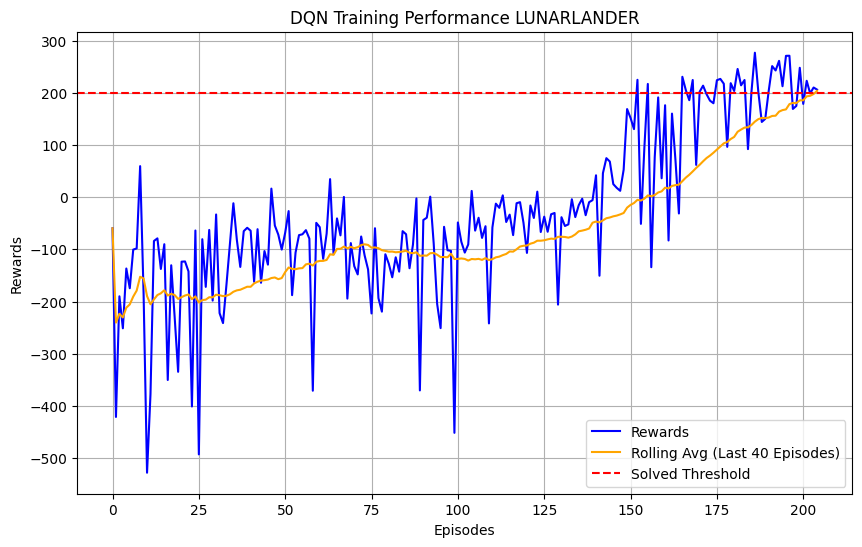

In [12]:
# Plot rewards with rolling average

plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last '+str(ROLLING_WINDOW) +' Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DQN Training Performance LUNARLANDER')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

#### **Simulation - Testing 10 episodes with the DQN Network**

In [9]:
# Testing for 10 episodes
start_time = time.time()

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    while True:
        # Use the trained model for testing
        action_vals = DQN.predict(state, verbose=0)  # Predict action values
        action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1
        if done or truncated:
            print(f"Test Episode: {e_test + 1:2}/10, Reward: {total_reward:7.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode:  1/10, Reward:  231.35, Steps: 428
Test Episode:  2/10, Reward:  204.92, Steps: 384
Test Episode:  3/10, Reward:  210.33, Steps: 382
Test Episode:  4/10, Reward:  267.33, Steps: 433
Test Episode:  5/10, Reward:  120.54, Steps: 1000
Test Episode:  6/10, Reward:  248.65, Steps: 368
Test Episode:  7/10, Reward:  233.28, Steps: 445
Test Episode:  8/10, Reward:  192.12, Steps: 455
Test Episode:  9/10, Reward:   59.49, Steps: 1000
Test Episode: 10/10, Reward:  215.83, Steps: 451
Testing completed in 3.86 minutes


#### **Rendering 1 episode**

In [10]:
# Test the trained agent with video rendering
# This code is useful if you are using colab otherwise use render_mode='human'
env = gym.make(('LunarLander-v3'), render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    action_vals = DQN.predict(state, verbose=0)  # Predict action values
    action = np.argmax(action_vals[0])           # Choose the action with the highest Q-value

    next_state, reward, done, truncated, _ = env.step(action)
    frames.append(env.render())                  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done or truncated:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='LUNARLANDER_DQN.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename='LUNARLANDER_DQN_CL.gif')


Rendered Test Episode Reward: 263.91
Saved GIF to: ./LUNARLANDER_DQN_CL.gif


In [11]:
import session_info
session_info.show(html=False)

-----
PIL                 11.0.0
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Jan 17 2025, 18:03:48) [GCC 13.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-02-08 12:59
